# Neural Q-learning

## Basic Q-learning

\[TODO: ADD REFERENCES\]

Let us consider a reinforcement learning problem consisting of an agent $A$ interacting with an environment $\text{env}$: the environment is in a state $s$, observed by the agent, which in turns takes an action $a$ following a policy $\pi(s)$ which might be deterministic (in which case $\pi$ is a function of the state space) or stochastic ($\pi(s)$ is then a probability distribution over the action space at state $s$). In response, the environment gives a reward $r$ to the agent, evolves to state $s'= env(s,a)$ (either stochastically or deterministically) and either terminates or awaits a new action from the agent.

A given policy allows us to attribute a value to each state as the total expected reward when following the policy, including a discount rate $\gamma$ to accomodate un-terminating processes:
$$v_\pi (s) =\mathbb{E}\left(\sum_{k=0}^\infty \gamma^k r_k\right),\qquad a_i\sim \pi(s_i),\ s_{i+1}\sim \text{env}(a_i,s_i),\ r_i = \text{reward}(s_i,a_i),$$
where we include finite episodes by making final states stationary and yield 0 reward whatever the action.

If we have a given policy $\pi$ and want to improve, we need to be able to "look around". This motivates the introduction of the Q-value function, which quantifies the value not following the policy for one step:

$$Q(s,a) = \text{reward}(s,a) + \gamma v_\pi(\text{env}(s,a))$$

In the case of an environment with a finite number of states and actions, Policy Improvement uses this function to steadily evolve the policy toward a better one: we just need to tabulate the possible rewards ands evolutions and replace $\pi(s)$ by $\underset{a}{\text{argmax}} Q(s,a)$. This always yields a policy at least as good as the previous one.

In a case that is too complex to exhaustively tabulate, Q-learning provides a solution. Indeed, inspired by what we have seen before, we can imagine defining an arbitrary Q-function over state-action pairs. From such a function, we can define a greedy deterministic policy as before as $\pi_Q(s) = \underset{a}{\text{argmax}} Q(s,a)$.

Of course, for a general function $Q(s,a)$, we have no guarantee that $Q$ is the Q-function of $\pi_Q$. The consistency condition for this to be the case is 

$$Q(s,a) =  \text{reward}(s,a) + \gamma \underset{a'}{\text{max}}Q(\text{env}(s,a),a')$$

In a tabulable environment, usual Q-learning defines a random $Q$ function and follows $\pi_Q$ in an $\epsilon$-greedy way (*i.e.* it follows $\pi_Q$ with probability $1-\epsilon$ and takes a random action with probability $\epsilon$). The transition is observed, the reward is collected, and $Q(s,a)$ is updated so that it tends to self-consistency:

$$Q(s,a) = (1-\alpha) Q(s,a) + \alpha (\text{reward}(s,a) + \gamma \underset{a'}{\text{max}}Q(\text{env}(s,a),a'))$$

This should converge to a function $Q$ which is the Q-value of its associated greedy policy $\pi_Q$. Furthermore, if we have an optimal policy $\pi$, we can always consider its true $Q$ value $Q_\pi$. If $\pi$ is optimal, trying to update the policy over the next step using policy improvement should yield the same action as the policy itself, *i.e.* $\pi^* = \pi_{Q_\pi^*}$ and $Q_\pi$ is the Q-value of its greedy policy. On the other hand, if $Q_\pi$ is the Q-value of its greedy policy, we have

$$Q(s,a) =  \text{reward}(s,a) + \gamma \underset{a'}{\text{max}}Q(\text{env}(s,a),a')$$

meaning that applying policy improvement yields exactly the same policy.
*Note: being stable under policy improvement might not imply global optimality, I need to check this*

## Neural Q-learning

In the case where the state space is not tabulable (for example when it is continuous), we

# Code and results

In [1]:
import numpy as np
import gym
from collections import namedtuple
env = gym.make("CartPole-v1")
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from copy import deepcopy
from gym import wrappers
from time import time
from PIL import Image

/Users/ndeutsch/code/reinforcement-learning-exercises/venv_rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Implementation

In [2]:
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# The target network is the same but non-trainable
class QNetStatic(QNet):

    def __init__(self):
        super(QNetStatic, self).__init__()       
        for param in self.parameters():
            param.requires_grad=False

In [3]:
# Torch version of the experience buffer
class ExperienceBuffer:
    def __init__(self,capacity=10):
        self.capacity = capacity
        self.initial_states = torch.zeros((capacity,4),requires_grad=False)
        self.actions = torch.zeros(capacity,dtype=np.int,requires_grad=False)
        self.rewards = torch.zeros(capacity,requires_grad=False)
        self.final_states = torch.zeros((capacity,4),requires_grad=False)
        self.terminal = torch.zeros(capacity,dtype=np.int,requires_grad=False)
        self.head = 0
        self.full = False
        
    def collect(self,s,a,r,st,status):
        self.initial_states[self.head] = s
        self.actions[self.head] = a
        self.rewards[self.head] = r
        self.final_states[self.head] = st
        self.terminal[self.head] = status
        self.head = (self.head + 1) % self.capacity
        if not self.full:
            if self.head == self.capacity-1:
                self.full = True
        
    def batch(self,batch_size):
        if self.full:
            indices = torch.randint(0, self.capacity, (batch_size,))
        else:
            indices = torch.randint(0, self.head+1, (batch_size,))
        return self.initial_states[indices], self.actions[indices], self.rewards[indices],self.final_states[indices],self.terminal[indices]
    

In [4]:
def process_memory(model,discount_rate,initial_states,actions,rewards,final_states,terminal):
    predictions = model(final_states)
    state_values = torch.max(predictions,axis=-1)
    targets = rewards + discount_rate*(1.-terminal)*state_values.values
    return targets,actions,initial_states

In [5]:
def train_nns_on_batch(model_to_train,target_model,batch_size,experience_buffer,discount_rate=0.99,learning_rate=0.01,optimizer=None):
    # Collect experience and prepare predictions and targets
    experience = experience_buffer.batch(batch_size)
    targets,actions,initial_states = process_memory(target_model,discount_rate,*experience)
    
    # start tracking gradients if needed, empty gradient buffers
    model_to_train.train()
    model_to_train.zero_grad()
    predicted_values = model_to_train(initial_states)[torch.arange(batch_size),actions]
    loss = torch.mean((predicted_values-targets)**2)
    # Compute gradients
    loss.backward()
    # apply gradient descent (basic sgd) - turns out to work quite well 
    if optimizer is None:
        for param in model_to_train.parameters():
            old_data=param.data.clone()
            param.data.sub_(param.grad.data * learning_rate)
    else:
        optimizer.step()
    
    # We're returning a lot of data for debugging
    return loss

## Training

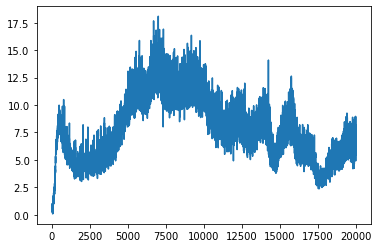

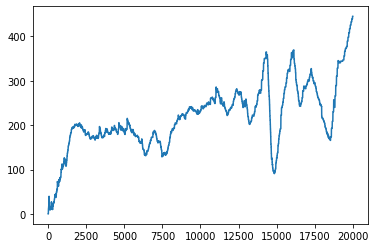

In [6]:
# Running the training function

# Initialization of the main objects
buffer = ExperienceBuffer(capacity=100000)
training_qnet = QNet()
target_qnet = QNetStatic()
target_qnet.load_state_dict(training_qnet.state_dict())
# Double ensure that no training is even attempted on the target
target_qnet.eval()

# My short experience: tuning the lr of basic, hand-applied SGD, is easier than advanced stuff - for this task
optimizer = None #torch.optim.RMSprop(training_qnet.parameters(),lr=0.0001,eps=0.1,alpha=0.9)

# Hyper-parameters: target refresh rate and greediness
C = 20
epsilon=0.1


# Pretty progress bar
progress_bar = tqdm(range(100000))
###############
# Telemetry

# For plotting
history = {'loss':[],'avg_reward':[]}

# episode length
current_run = 0
# Top episode length (to schedule saves)
longest_run = 0

# running avg length with an update weigh
avg_run = 0
weight = 0.1

# Top averaged length (to smooth out fluctuations)
best_avg = 0

# NN states to replay performance along the training
saved_states = [training_qnet.state_dict()]

state =torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)

for j in progress_bar:
    # Fill up 10 epsilon-greedy runs following the Q-net
    # We are not training now
    training_qnet.eval()
    for i in range(10):
        # Epsilon-greedy run
        if np.random.rand()<epsilon:
            action = torch.tensor(env.action_space.sample(),dtype=torch.int32)
        else:
            action=(torch.argmax(training_qnet(state.reshape(1,4))))
        # Take the action, observe the result and memorize it all
        observation, reward, done, info = env.step(action.numpy())
        new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
        buffer.collect(state,action,torch.tensor(reward,dtype=torch.float32,requires_grad=False),new_state,done)
        #print(state,action,reward,new_state,done)
        
        if done:
            # At episode end, reset, update metrics
            torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
            longest_run = max(longest_run,current_run)
            avg_run = current_run*weight + avg_run*(1-weight)

            # if we improved 10% over the last best perf, update best perf and save
            if avg_run > 1.1*best_avg:
                best_avg = avg_run
                saved_states.append(deepcopy(training_qnet.state_dict()))
            # Reset epsiode lenght counter
            current_run=0
        else:
            state=new_state
            current_run+=1
        
    # Take one gradient step on a batch
    loss = train_nns_on_batch(training_qnet,target_qnet,10000,buffer,discount_rate=0.999,learning_rate=0.01,optimizer=optimizer)
    
    # Log plot metrics
    history['loss'].append(loss)
    history['avg_reward'].append(avg_run)
    
    # update progress bar with metrics for impatient observers
    progress_bar.set_description("Loss = {0:.2f} | MAVG {1} | AVG {2}".format(loss,int(best_avg), int(avg_run)))

    # Every C steps, update the target
    if j%C==0:
        target_qnet.load_state_dict(training_qnet.state_dict())        

env.reset()
env.close()

plt.plot(history['loss'])
plt.show()
plt.plot(history['avg_reward'])
plt.show()


The average reward climbs all the way to very close to 500, which is the point where the episode is terminated if the pole has not fallen.

The loss has a behavior that might look suprising as it is trending *up* instead of down as one would expect for training. The reason why this is is that by frequently updating the target network, we keep chasing a moving target. We can therefore expect pattern of steadily decreasing loss followed by jumps when the target is updated, which we can observe by zooming into the loss curve.

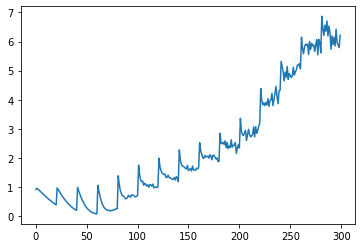

In [7]:
plt.plot(history['loss'][:300])
plt.show()


The overall upward trend, which is driven by the target updates can be understood by looking at how the reward estimates are built. At each step, the target value for the Q-value is $1+\underset{a}{\text{max}}Q(s,a)$ or $1$ depending on whether the episode is running or terminating. As we are using Xavier initialization are we start with small values of the inputs, the outputs are expected to be of order $1.$, meaning that the targets are mostly between $1.$ and $2.$ 

After training for a while, the agent has learned to hold the pole up for longer and so the expected reward for initial positions at least is of the order of the current performance of the agent. 
As a result, the target for many positions, and *a fortiori* for those that are actually visited by the trained agent keeps growing so that even if the training network keeps following the target within a good margin of error, the squared residual, which we use as a loss, can be expected to grow.

One way out of this could be to somehow normalize the loss so that it represents a residual error rate. The first idea would be to divide each residual by the target, but this skews the loss by giving more relative weights to low reward states, we we care the least about estimating properly. In order to not skew the relative weights, an overal factor needs to be applied, such as the average target over the batch. It would be interesting to see if this improves or deters learning:
- on the one hand this could stabilize learning rates as the gradient of the loss is proportional to the residual, leading to larger steps at the end of training.
- on the other hand, batch to batch fluctuations would lead to the same issue as for normalizing residuals individually: batches with overall lower rewards would gain a relatively larger weight in the training, which is again undesirable.

In [ ]:
# save the model state to rebuild later
torch.save(saved_states[-1],"./model_state_1")
# load a saved state
training_qnet.load_state_dict(torch.load("./model_state_1"))

## Rendering

### Native Gym rendering

In [13]:
training_qnet.load_state_dict(saved_states[-1])
training_qnet.eval()
state =torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
for i in range(500):
    action=(torch.argmax(training_qnet(state.reshape(1,4))))

    observation, reward, done, info = env.step(action.numpy())
    new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
    if done:
        torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
        print(i)
    else:
        state=new_state
    env.render()
env.close()

499


### MP4 Video Rendering using monitor

In [72]:
video_env = wrappers.Monitor(env, './videos/' + str(time()) + '/')

training_qnet.load_state_dict(saved_states[-1])
training_qnet.eval()

state =torch.tensor( (video_env.reset().astype(np.float32)),requires_grad=False)
for i in range(500):

        action=(torch.argmax(training_qnet(state.reshape(1,4))))

        observation, reward, done, info = video_env.step(action.numpy())
        new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)
        if done:
            print(i)
            break
            #torch.tensor( (video_env.reset().astype(np.float32)),requires_grad=False)
        else:
            state=new_state
video_env.close()

499


### Generating GIFs using PIL and render(mode='rgb_array')

In [10]:
images = [[] for i in range(4)]

for k in range(4):
    training_qnet.load_state_dict(saved_states[len(saved_states)-1-k*(len(saved_states)-1)//4])
    training_qnet.eval()
    state =torch.tensor( (env.reset().astype(np.float32)),requires_grad=False)
    for i in range(200):
        action=(torch.argmax(training_qnet(state.reshape(1,4))))

        observation, reward, done, info = env.step(action.numpy())
        new_state = torch.tensor( (observation.astype(np.float32)),requires_grad=False)

        # Note that here we forgo the usual restarting when the episode is done
        # this makes nicer gifs with the pole running wildly before being trained
        state=new_state

        # env.render(mode='rgb_array') returns a numpy array
        images[k].append(Image.fromarray(env.render(mode='rgb_array'))) 
    env.close()
    
    
for k in range(4):
    images[k][0].save('episodes_step_{}.gif'.format(len(saved_states)-k*len(saved_states)//4),
               save_all=True, append_images=images[k][1:], optimize=True, duration=20, loop=0)

In [23]:
from IPython.display import HTML

HTML('<h1>Step 8</h1> \
<img src="./episodes_step_8.gif">\
 <h1>Step 15</h1> \
 <img src="./episodes_step_15.gif">\
 <h1>Step 22</h1> \
 <img src="./episodes_step_22.gif">\
 <h1>Step 29</h1> \
 <img src="./episodes_step_29.gif">')